In [1]:
%load_ext Cython

import pandas as pd
import numpy as np
import datetime
import random
import pickle
from surprise import SVD
from surprise import Dataset
from surprise import Reader
import statistics

from explanation import InfluenceExplainer

In [2]:
from recommender_algo.editable_svd import EditableSVD

In [3]:
# Load pre-trained model
with open("algo-20m.pickle", "rb") as fp:
    algo = pickle.load(fp)
    
# Init list of movies
movies_df = pd.read_csv("../data/ml-20m/movies.csv", dtype={
   'movieId': int,
   'title': str,
   'genres': str,
})
movies_map = {}
for index, row in movies_df.iterrows():
    movies_map[row['movieId']] = row['title']

user_id = 548328920
means_list = []
std_list = []
for i in range(100):
    # create 10 ratings for random films
    movies_to_rate = []
    for k in range(10):
        key = random.choice(list(movies_map.keys()))
        movies_to_rate.append(key)
    user_rated_items = { key: random.randint(1, 5) for key in movies_to_rate }
    print(user_rated_items)
    
    # Generate recommendations
    top_n = []
    for i in movies_map:
        # Filter out rated movies
        if i not in user_rated_items:
            prediction = algo.predict(user_id, i)
            top_n.append((prediction.iid, prediction.est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    top_n.sort(key=lambda x: x[1], reverse=True)
    top_n = top_n[:6]
    print(top_n)
    
    influence_explainer = InfluenceExplainer(user_id, user_rated_items, algo)
    
    for recommendation in top_n:        
        film_influences = {}
        for k in range(20):
            algo.fit_new_user(user_id, user_rated_items)
            explanation = influence_explainer.generate_explanation_for_all(recommendation)
            algo.delete_user(user_id)
            for (key, influence) in explanation:
                if key not in film_influences:
                    film_influences[key] = []
                film_influences[key].append(influence)
        # get mean, std of calculated influences
        for influences_list in film_influences.values():
            means_list.append(statistics.mean(influences_list))
            std_list.append(statistics.stdev(influences_list))
print("Mean: " + str(statistics.mean(means_list)) + ", std: " + str(statistics.stdev(std_list)))

{86173: 5, 33794: 3, 27136: 4, 113771: 3, 76279: 4, 90312: 4, 3603: 5, 3790: 5, 5370: 5, 105846: 4}
[(318, 4.463508447474829), (31948, 4.379273222755978), (100553, 4.328645293620024), (108583, 4.327742512748582), (26674, 4.32479110665059), (77177, 4.30319592142428)]
{278: 5, 106581: 5, 8885: 2, 27858: 1, 5595: 4, 102735: 3, 129996: 4, 103779: 2, 8843: 5, 83658: 3}
[(318, 4.463508447474829), (31948, 4.379273222755978), (100553, 4.328645293620024), (108583, 4.327742512748582), (26674, 4.32479110665059), (77177, 4.30319592142428)]
{27359: 1, 3274: 1, 33688: 5, 33191: 2, 92023: 2, 101944: 4, 129644: 3, 7090: 1, 107297: 4, 130504: 3}
[(318, 4.463508447474829), (31948, 4.379273222755978), (100553, 4.328645293620024), (108583, 4.327742512748582), (26674, 4.32479110665059), (77177, 4.30319592142428)]
{2293: 3, 5842: 1, 82589: 4, 6539: 1, 104673: 2, 5395: 5, 3982: 1, 131025: 3, 5543: 5, 5100: 2}
[(318, 4.463508447474829), (31948, 4.379273222755978), (100553, 4.328645293620024), (108583, 4.32774

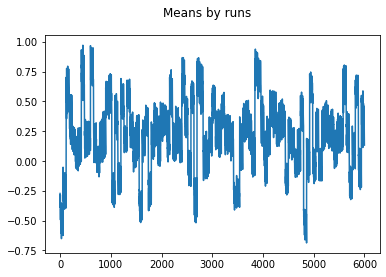

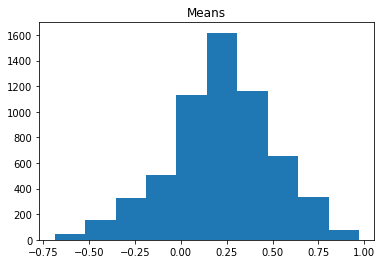

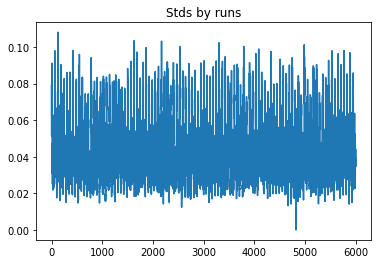

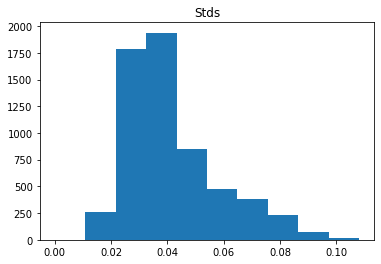

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure()

fig.suptitle('Means by runs')
plt.plot(range(len(means_list)), means_list)
fig.savefig('exp1_mean-runs.png')

fig, ax = plt.subplots()
ax.set_title('Means')
ax.hist(means_list)
fig.savefig('exp1_mean-hist.png')

fig, ax = plt.subplots()
ax.set_title('Stds by runs')
ax.plot(range(len(std_list)), std_list)
fig.savefig('exp1_std-runs.png')

fig, ax = plt.subplots()
ax.set_title('Stds')
ax.hist(std_list)
fig.savefig('exp1_std-hist.png')